In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

/srv/conda/envs/py36/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


In [2]:
def load_hcp100_bold(path, subjects=range(1, 101)):
    """
    Loads the BOLD data of the HCP100 dataset.
    
    Parameters
    ----------
    path : str
           path to data folder

    subjects : iterable
               iterable with ids of subjects to be loaded
               by default, all 100 subjects will be loaded
             
    Returns
    -------
    data : list of 2d nd arrays
           synthetic BOLD time series (numTRs X numROIs) of n subjects
           output format matches nilearn.ConnectivityMeasure.fit_transform() input format
    """
    data = []
    for sub in subjects:
        fullfile = os.path.join(path, f"sub{sub:03}_BOLD_timeseries_HCP.csv")
        data.append(np.asarray(pd.read_csv(fullfile, header=None)).transpose())
        
    return data

def load_hcp100_dti(path, subjects=range(1, 101)):
    """
    Loads the DTI structural connectivity data of the HCP100 dataset.
    
    Parameters
    ----------
    path : str
           path to data folder

    subjects : iterable
               iterable with ids of subjects to be loaded
               by default, all 100 subjects will be loaded
             
    Returns
    -------
    data : list of 2d nd arrays
           empirical structural connectivity matrices (numROIs X numROIs) of HCP subjects
           output format matches nilearn.ConnectivityMeasure.fit_transform() input format
    """
    data = []
    for sub in subjects:
        fullfile = os.path.join(path, f"sub{sub:03}_DTI_fibers_HCP.csv")
        data.append(np.asarray(pd.read_csv(fullfile, header=None)))
        
    return data

In [3]:
# load BOLD data and structural connectivity
path = "/home/jovyan/shared/hcp_connectivity/schaefer100"
empirical_bold = load_hcp100_bold(path)
empirical_SC = load_hcp100_dti(path)
print(f"empirical BOLD data shape: {empirical_bold[0].shape}, empirical SC shape: {empirical_SC[0].shape}")

empirical BOLD data shape: (1189, 100), empirical SC shape: (100, 100)


In [4]:
# compute vectorized functional connectivity matrix: numEdges x numSubs
conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
empirical_FC = conn_measure.fit_transform(empirical_bold).transpose()
print(f"empirical FC shape: {empirical_FC.shape}")

empirical FC shape: (4950, 100)


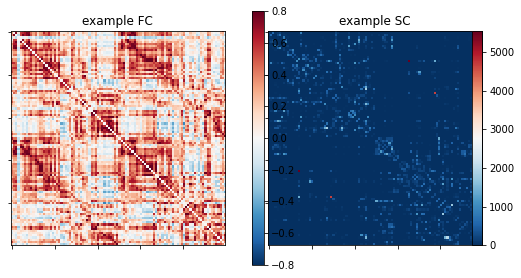

In [5]:
# plot example FC and SC
from nilearn import plotting

conn_measure2d = ConnectivityMeasure(kind='correlation', vectorize=False, discard_diagonal=False)
exampleFC = conn_measure2d.fit_transform([empirical_bold[0]]).squeeze()
np.fill_diagonal(exampleFC, 0)
exampleSC = empirical_SC[0]

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 22));
plotting.plot_matrix(exampleFC, vmax=0.8, vmin=-0.8, colorbar=True, axes=ax0);
plotting.plot_matrix(exampleSC, colorbar=True, axes=ax1);
ax0.set_title('example FC');
ax1.set_title('example SC');

In [6]:
import fastdmf as dmf
from bayes_opt import BayesianOptimization, UtilityFunction
from ks_metric import ks_score

In [7]:
class BrainModel():
    """
    Whole-brain model class. As of yet, BrainModel is a DMF whole-brain model as per FastDMF.
    """
    
    def __init__(self, **kwargs):
        # FastDMF attributes
        params = kwargs.get('params', {})
        self.params = dmf.default_params(**params)
        
        # additional attributes
        self.pbounds = kwargs.get('pbounds', {'G': [0.1, 5]}) # bounds of all free model parameters as dict
        self._loss = np.inf 
        
    def get_loss(self):
        return self._loss
    
    def run(self, ms):
        """
        Returns 2d array of synthetic BOLD data where rows=seconds and cols=brain regions.
        """
        return dmf.run(self.params, ms)
            
    def utility(self, empirical_FC, ms = 120000):
        """ 
        Computes negative loss of DMF whole-brain model fit to empirical functioncal connectivity data.

        Parameters
        ----------
        empirical_FC : 0D array
                       vectorized lower/ upper triangular empirical functional connectivity matrix
                       should NOT contain self-correlation values of regional timeseries with themselves
        
        G : float
            global coupling parameter G
            if given, model will run with a different G parameter than self.params['G']

        ms : int
             number of milisecond time steps of bold data to be synthesized for fitting

        Returns
        -------
        result : float
                 negative loss; negative ks-distance between functional connectivity value 
                 distributions of synthesized versus empirical data
        """

        # simulate BOLD data
        bold = self.run(ms)

        # get functional connectivity of unique pairs of model-brain regions
        FC_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
        synthetic_FC = FC_measure.fit_transform([np.transpose(bold)]).flatten()

        # check dimensions of input (TODO: perform check before running simulation)
        assert len(synthetic_FC) == len(empirical_FC), f"empirical_FC must have the shape {synthetic_FC.shape}."

        # return ks-distance between synthetic and empirical functional connectivity distributions
        category = np.concatenate((np.zeros(len(synthetic_FC)), np.ones(len(empirical_FC))), axis=0)
        stacked_data = np.concatenate((synthetic_FC, empirical_FC), axis=0)
        ks_dist = ks_score(category, stacked_data)
        return -ks_dist
    
    def _evaluate_clone(self, empirical_FC, G, ms = 120000):
        # make clone
        clone = BrainModel(**self.__dict__)
        # change G
        clone.params['G'] = G
        # evaluate clone
        return clone.utility(empirical_FC, ms=ms)

    def fit(self, empirical_FC, ms=120000, init_points=5, n_iter=10):
        """
        Uses Bayesian Optimization to find optimal model parameters so as to fit DMF whole-brain 
        model to empirical data.

        Parameters
        ----------
        empirical_FC : 0D array
                       vectorized lower/ upper triangular empirical functional connectivity matrix
                       should NOT contain self-correlation values of regional timeseries with themselves
                       
        ms : int
             number of milisecond time steps of bold data to be synthesized for fitting
             
        init_points : int
                      number of sampled model parameters to be evaluated at each iteration
                      
        n_iter : int
                 number of iterations
        """
        # create BayesianOptimization optimizer and maximize utility
        # lambda x: x if x > threshold_value else 0
        optimizer = BayesianOptimization(f = lambda G: self._evaluate_clone(empirical_FC, G, ms=ms), 
                                         pbounds = self.pbounds)
        optimizer.maximize(init_points = init_points, n_iter = n_iter)
        
        # update model parameter and loss
        self.params['G'] = optimizer.max['params']['G']
        self._loss = optimizer.max['target']

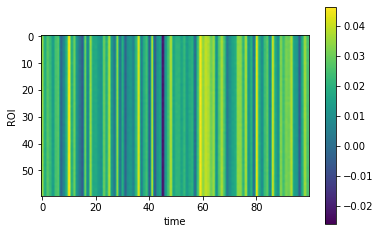

In [8]:
# test run

# simulate some BOLD data
model = BrainModel()
bold = model.run(120000)

# plot synthetic BOLD data
fig, ax = plt.subplots()
im = ax.imshow(bold.transpose())
ax.set_ylabel('time (s)');
ax.set_xlabel('brain regions');
cbar = ax.figure.colorbar(im, ax=ax)

In [9]:
# test: fit model to empirical FC of subject 0
import time

exampleSub = 0

start = time.time()
model = BrainModel()
model.fit(empirical_FC[:, exampleSub], ms=120000, init_points=5, n_iter=10)
end = time.time()
print(f"time passed: {(end-start)/60} minutes.")

|   iter    |  target   |     G     |
-------------------------------------
| 1         | -73.76    | 3.286     |
| 2         | -73.92    | 2.742     |
| 3         | -75.68    | 0.1936    |
| 4         | -63.56    | 1.649     |
| 5         | -71.05    | 1.032     |
| 6         | -73.96    | 1.032     |
| 7         | -70.99    | 1.032     |
| 8         | -73.31    | 1.649     |
| 9         | -71.62    | 1.031     |
| 10        | -73.07    | 1.031     |
| 11        | -65.37    | 1.649     |
| 12        | -42.89    | 1.649     |
| 13        | -75.09    | 0.6086    |
| 14        | -73.39    | 4.813     |
| 15        | -66.36    | 1.649     |
time passed: 10.921931727727253 minutes.


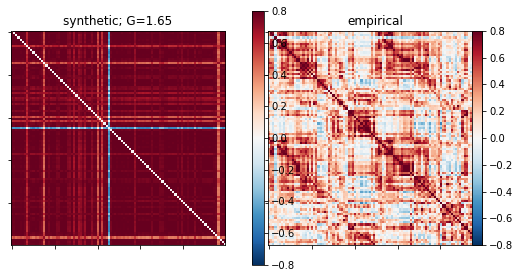

In [14]:
# visual assessment of model fit

# synthesize BOLD data
timesteps = 120000 # miliseconds
bold = model.run(timesteps)

# compute synthetic FC
FCsynth = conn_measure2d.fit_transform([bold.transpose()]).squeeze()
np.fill_diagonal(FCsynth, 0)

# compute empirical FC of sub0
FCemp = conn_measure2d.fit_transform([empirical_bold[exampleSub]]).squeeze()

# plot synthetic and empirical FC next to each other
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 22));
plotting.plot_matrix(FCsynth, vmax=0.8, vmin=-0.8, colorbar=True, axes=ax0);
plotting.plot_matrix(FCemp, vmax=0.8, vmin=-0.8, colorbar=True, axes=ax1);
ax0.set_title(f"synthetic; G={np.round(model.params['G'], 2)}");
ax1.set_title('empirical');

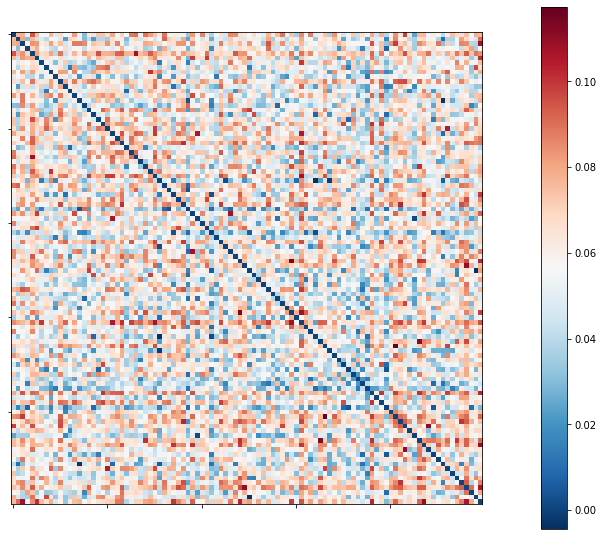

In [18]:
# test run with the default (consensus) structural connectivity matrix, provided by FastDMF
a = dmf.run(dmf.default_params(), 120000)

# compute synthetic FC
b = conn_measure2d.fit_transform([a.transpose()]).squeeze()
np.fill_diagonal(b, 0)

# plot synthetic FC
fig, ax0 = plt.subplots(1, 1, figsize=(10, 12));
plotting.plot_matrix(b, colorbar=True, axes=ax0);